<div align="center">

#     ✨ AML Assignment 5✨  
# Transfer Learning : Duck vs Chicken Classification
## 🧑‍🎓 Bhuvnesh Sahu  
### 📘 MDS202316

</div>

In [28]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm, auto

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [2]:
base_path = "/content/drive/MyDrive/AML/data"

chicken_dirs = {
    "train": os.path.join(base_path, "chicken/train"),
    "test": os.path.join(base_path, "chicken/test"),
    "val": os.path.join(base_path, "chicken/val")
}

duck_dirs = {
    "train": os.path.join(base_path, "duck/train"),
    "test": os.path.join(base_path, "duck/test"),
    "val": os.path.join(base_path, "duck/val")
}

# Target structure for merged dataset
merged_base = "/content/merged_dataset"
splits = ["train", "test", "val"]
labels = ["chicken", "duck"]

# Create necessary folders
for split in splits:
    for label in labels:
        os.makedirs(os.path.join(merged_base, split, label), exist_ok=True)

# Function to copy data
def copy_data(source_dir, dest_dir):
    for item in os.listdir(source_dir):
        s = os.path.join(source_dir, item)
        d = os.path.join(dest_dir, item)
        if os.path.isfile(s):
            shutil.copy2(s, d)

# Copy files into merged folders
for split in splits:
    copy_data(chicken_dirs[split], os.path.join(merged_base, split, "chicken"))
    copy_data(duck_dirs[split], os.path.join(merged_base, split, "duck"))


In [3]:
# Step 1: Define individual transformation steps
resize_op = transforms.Resize(size=(224, 224))
to_tensor = transforms.ToTensor()
normalize_op = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

# Step 2: Combine transformations
augmentation_pipeline = transforms.Compose([
    resize_op,
    to_tensor,
    normalize_op
])

# Step 3: Paths to datasets
train_path = "/content/merged_dataset/train"
test_path = "/content/merged_dataset/test"
val_path= "/content/merged_dataset/val"

# Step 4: Load datasets with transformation applied
train_data = datasets.ImageFolder(root=train_path, transform=augmentation_pipeline)
test_data = datasets.ImageFolder(root=test_path, transform=augmentation_pipeline)
val_data = datasets.ImageFolder(root=val_path, transform=augmentation_pipeline)


# Step 5: Wrap datasets with DataLoader
batch_sz = 16
train_data_loader = DataLoader(dataset=train_data, batch_size=batch_sz, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=batch_sz, shuffle=False)
val_data_loader = DataLoader(dataset=val_data, batch_size=batch_sz, shuffle=False)


# Dataset

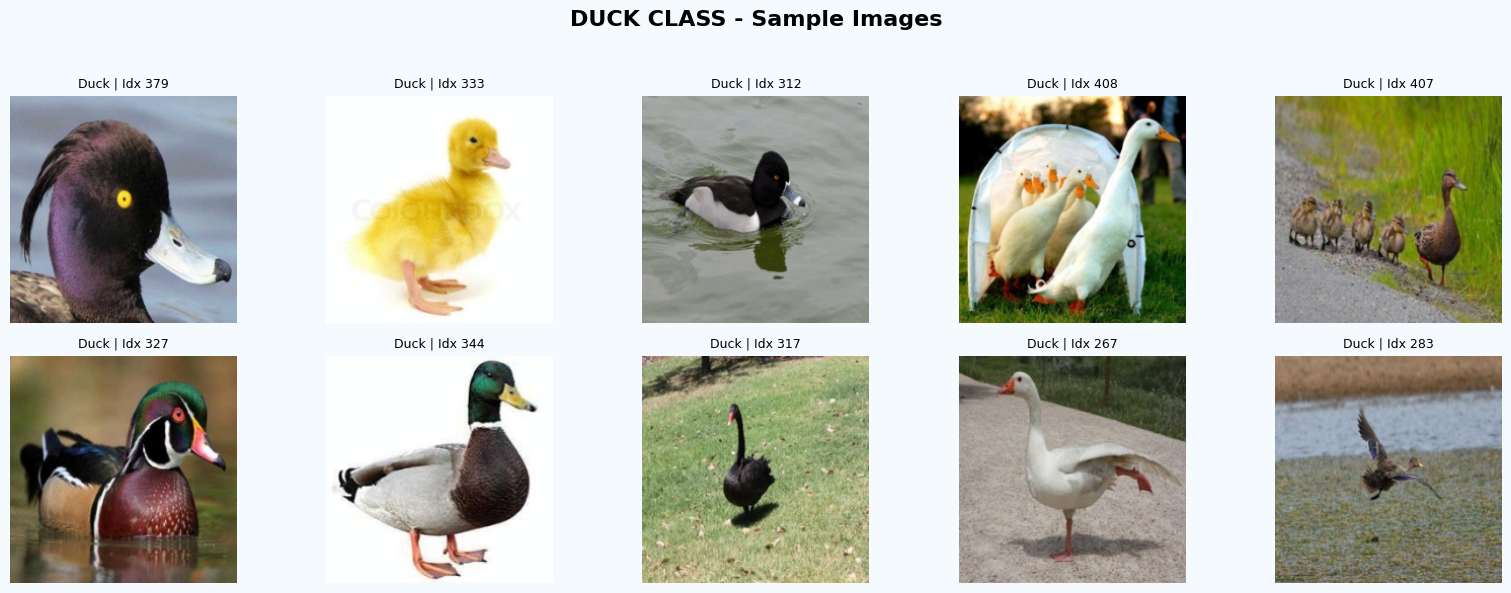

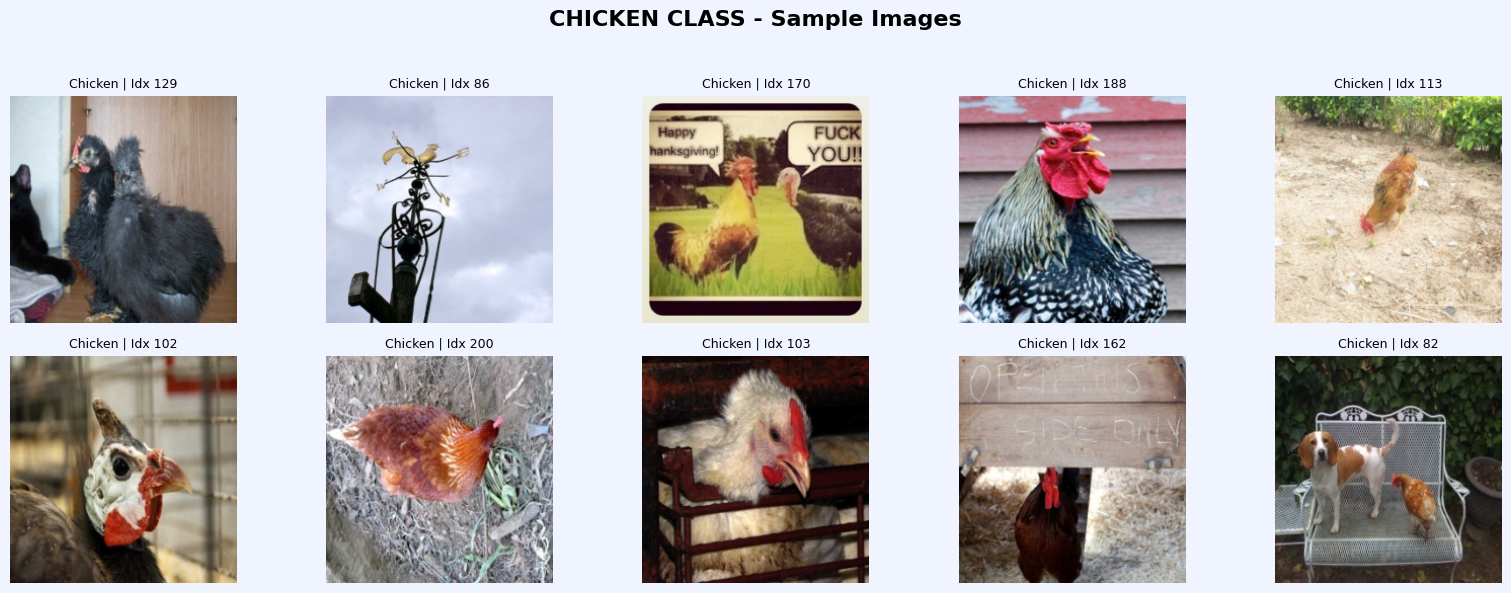

In [4]:
def display_class_grid(dataset, class_label, num_images=10, seed=None):
    if seed is not None:
        random.seed(seed)

    class_index = dataset.class_to_idx[class_label]
    indices = [i for i, (_, y) in enumerate(dataset.imgs) if y == class_index]
    chosen = random.sample(indices, num_images)

    rows, cols = 2, 5
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6))
    fig.suptitle(f"{class_label.upper()} CLASS - Sample Images", fontsize=16, weight='bold')
    fig.patch.set_facecolor(random.choice(['#f7f7f7', '#fef9f4', '#f0f4ff', '#f5faff']))

    for idx, ax in zip(chosen, axes.flatten()):
        img_tensor, _ = dataset[idx]
        img = img_tensor.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"{class_label.title()} | Idx {idx}", fontsize=9)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display 10 images (2 rows × 5 columns) for each class
display_class_grid(train_data, "duck", num_images=10)
display_class_grid(train_data, "chicken", num_images=10)


In [5]:
# Load ResNet18 backbone with pretrained weights
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers to use as feature extractor
for layer in base_model.parameters():
    layer.requires_grad = False

# Replace the fully connected (classification) head
input_dim = base_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(input_dim, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(256, 2)  # Two output classes
)
base_model.fc = new_head

# Enable training only on the new head
for layer in base_model.fc.parameters():
    layer.requires_grad = True

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

# Parameter count summary
trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in base_model.parameters() if not p.requires_grad)
print(f"🟢 Trainable Parameters   : {trainable:,}")
print(f"🔒 Frozen Parameters      : {frozen:,}\n")

# Optional: Model architecture summary
print("🔧 Modified ResNet18 Model Architecture:\n")
print(base_model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


🟢 Trainable Parameters   : 131,842
🔒 Frozen Parameters      : 11,176,512

🔧 Modified ResNet18 Model Architecture:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): 

# Traing ResNet18

🛠 Starting training for 15 epochs...



  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 01 complete | Avg Loss: 0.0652
✅ Validation Loss: 0.2145


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 02 complete | Avg Loss: 0.1668
✅ Validation Loss: 0.2411


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 03 complete | Avg Loss: 0.1048
✅ Validation Loss: 0.2767


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 04 complete | Avg Loss: 0.0918
✅ Validation Loss: 0.2195


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 05 complete | Avg Loss: 0.0595
✅ Validation Loss: 0.2546


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 06 complete | Avg Loss: 0.0682
✅ Validation Loss: 0.2515


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 07 complete | Avg Loss: 0.0621
✅ Validation Loss: 0.2197


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 08 complete | Avg Loss: 0.0553
✅ Validation Loss: 0.2892


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 09 complete | Avg Loss: 0.0652
✅ Validation Loss: 0.2898


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 10 complete | Avg Loss: 0.1853
✅ Validation Loss: 0.2293


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 11 complete | Avg Loss: 0.1685
✅ Validation Loss: 0.2624


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 12 complete | Avg Loss: 0.3029
✅ Validation Loss: 0.2868


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 13 complete | Avg Loss: 0.0755
✅ Validation Loss: 0.1985


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 14 complete | Avg Loss: 0.0598
✅ Validation Loss: 0.1922


  0%|          | 0/27 [00:00<?, ?it/s]

✅ Epoch 15 complete | Avg Loss: 0.0668
✅ Validation Loss: 0.2088


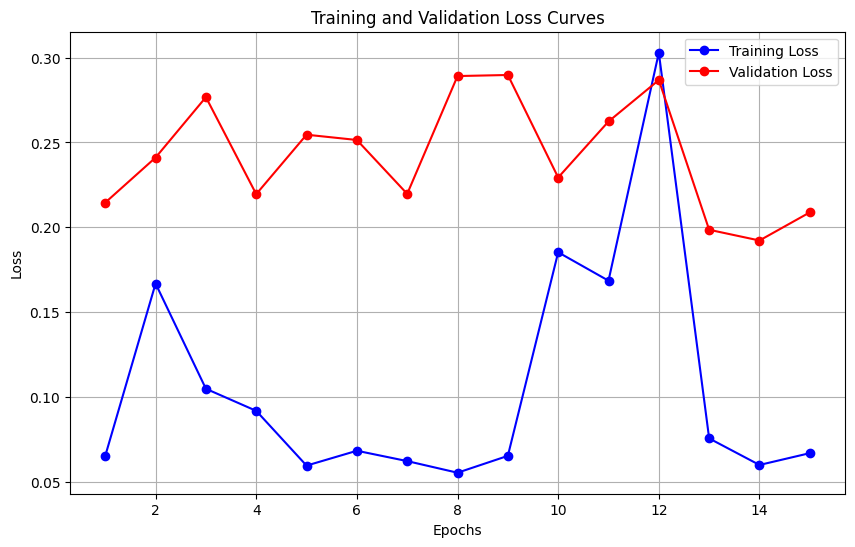

In [26]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=1e-3)

# Training settings
epochs = 15
print(f"🛠 Starting training for {epochs} epochs...\n")

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for ep in range(1, epochs + 1):
    base_model.train()
    epoch_loss = 0.0
    loop = tqdm(train_data_loader, total=len(train_data_loader), leave=False)
    loop.set_description(f"🔁 Epoch {ep:02d}")

    for batch_idx, (X, y) in enumerate(loop):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        preds = base_model(X)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        avg_loss = epoch_loss / (batch_idx + 1)
        loop.set_postfix(batch_loss=f"{avg_loss:.4f}")

    # Append training loss for this epoch
    train_losses.append(avg_loss)

    print(f"✅ Epoch {ep:02d} complete | Avg Loss: {avg_loss:.4f}")

    # Evaluate on validation set
    base_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_data_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            preds = base_model(X_val)
            batch_val_loss = loss_fn(preds, y_val)
            val_loss += batch_val_loss.item()

    avg_val_loss = val_loss / len(val_data_loader)
    val_losses.append(avg_val_loss)
    print(f"✅ Validation Loss: {avg_val_loss:.4f}")

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue", marker="o")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


# val data Accuracy


📊 Classification Report:
              precision    recall  f1-score   support

     chicken       0.90      0.95      0.93        40
        duck       0.95      0.90      0.92        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



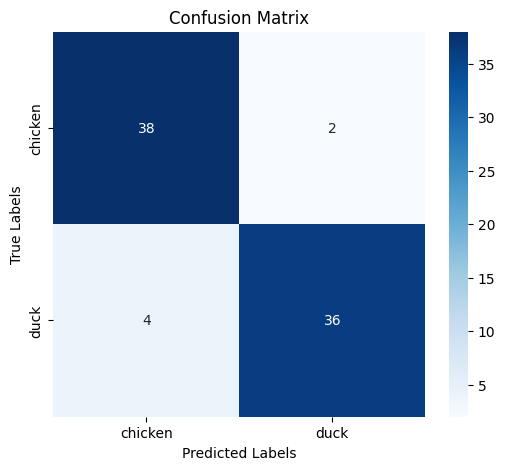

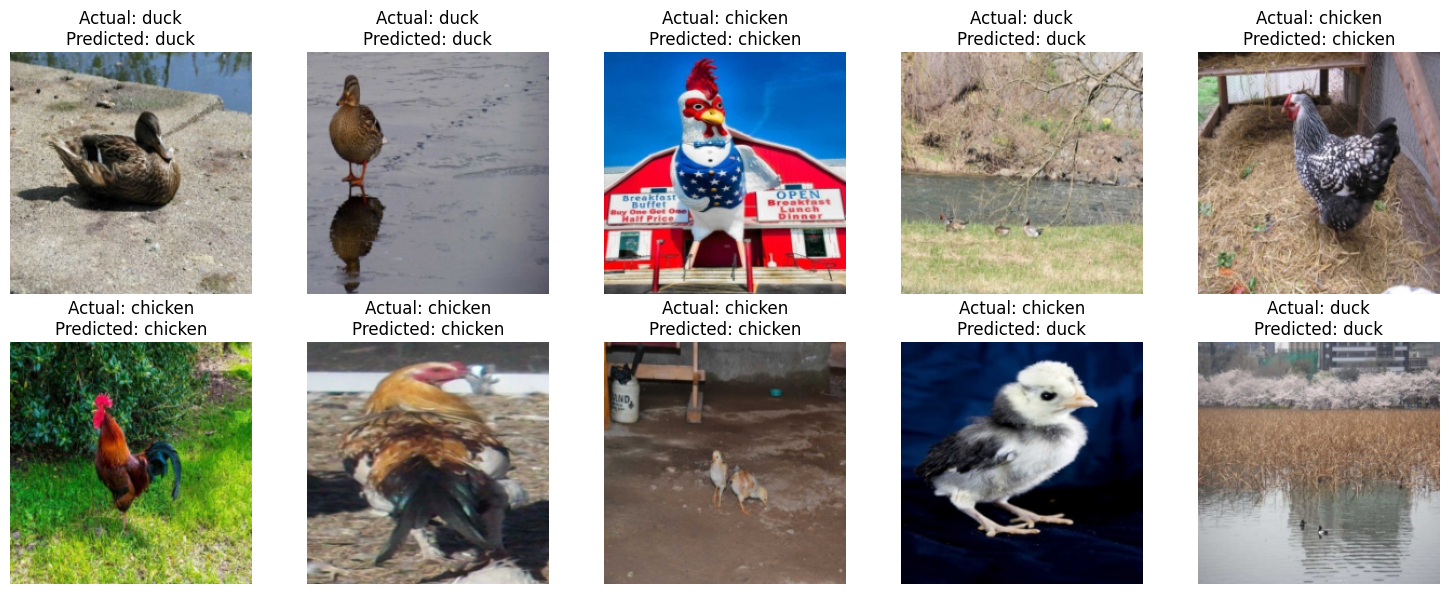


🏆 Accuracy: 92.500%


In [22]:
# Initialize lists to store results
true_labels = []
predicted_labels = []
sample_images_list = []
sample_labels_list = []
sample_predictions_list = []

# Iterate through the validation dataset
with torch.no_grad():
    for batch_images, batch_labels in val_data_loader:
        # Move to device
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        # Forward pass
        outputs = base_model(batch_images)
        _, predictions = torch.max(outputs, 1)

        # Collect true labels and predictions
        true_labels.extend(batch_labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

        # Store sample images and their corresponding labels and predictions
        sample_images_list.extend(batch_images.cpu())
        sample_labels_list.extend(batch_labels.cpu().numpy())
        sample_predictions_list.extend(predictions.cpu().numpy())

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=test_data.classes))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display random sample predictions (including both classes)
num_samples = 10  # Number of random samples to display (2 rows x 5 columns)
random_indices = random.sample(range(len(sample_images_list)), num_samples)

# Create a grid with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2x5 axes array to easily loop through them
axes = axes.flatten()

# Loop through the random indices and display each image with its actual and predicted labels
for i, idx in enumerate(random_indices):
    # Unnormalize the image
    image = sample_images_list[idx].permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    image = np.clip(image, 0, 1)  # Clip values to valid range

    # Get the actual and predicted labels
    actual_label = test_data.classes[sample_labels_list[idx]]  # Actual label from dataset
    predicted_label = test_data.classes[sample_predictions_list[idx]]  # Predicted label from model

    # Plot the image and add title with actual and predicted labels
    axes[i].imshow(image)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Optionally, print the accuracy
accuracy = sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"\n🏆 Accuracy: {accuracy * 100:.3f}%")


# Test data Accuracy


📊 Classification Report:
              precision    recall  f1-score   support

     chicken       0.97      0.97      0.97       100
        duck       0.97      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



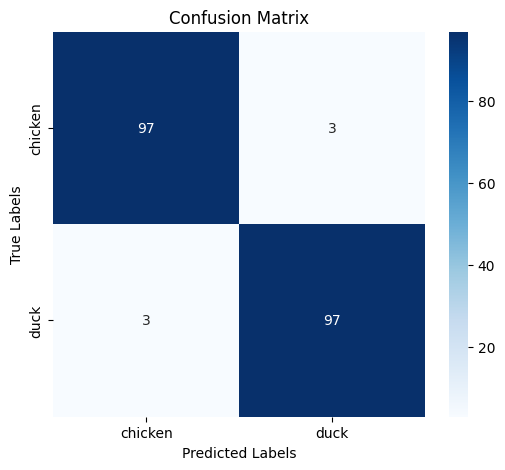

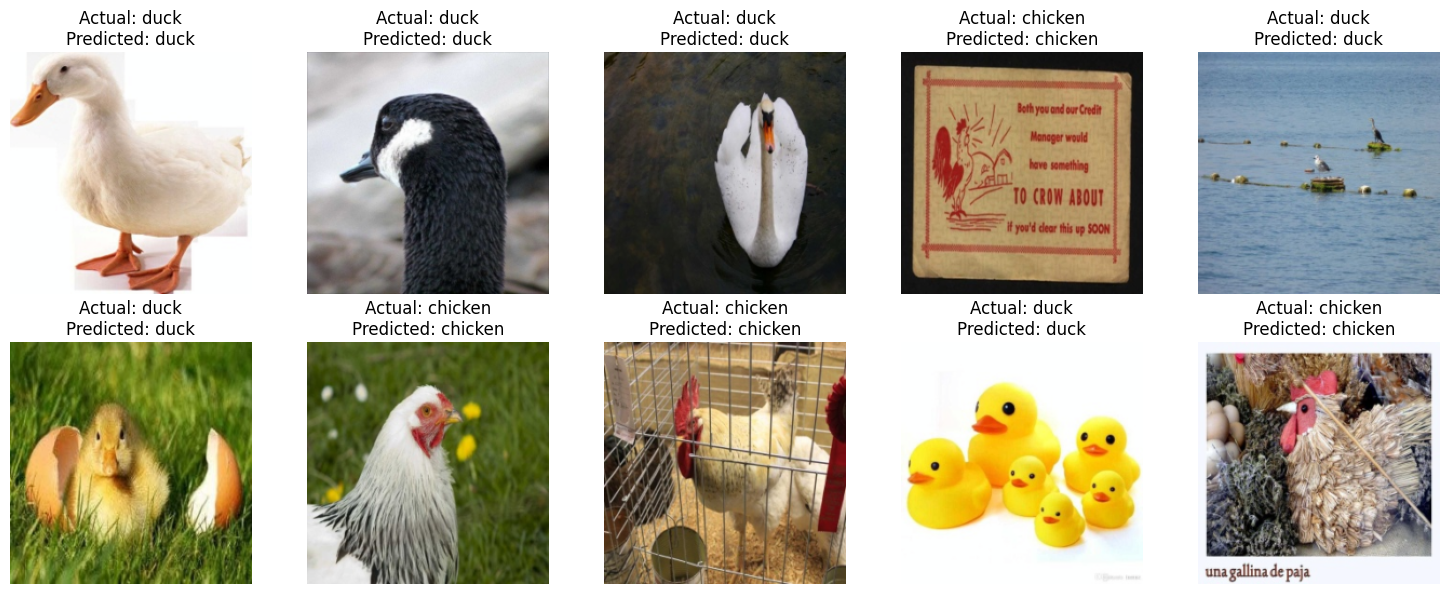


🏆 Accuracy: 97.000%


In [25]:
# Initialize lists to store results
true_labels = []
predicted_labels = []
sample_images_list = []
sample_labels_list = []
sample_predictions_list = []

# Iterate through the validation dataset
with torch.no_grad():
    for batch_images, batch_labels in test_data_loader:
        # Move to device
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        # Forward pass
        outputs = base_model(batch_images)
        _, predictions = torch.max(outputs, 1)

        # Collect true labels and predictions
        true_labels.extend(batch_labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

        # Store sample images and their corresponding labels and predictions
        sample_images_list.extend(batch_images.cpu())
        sample_labels_list.extend(batch_labels.cpu().numpy())
        sample_predictions_list.extend(predictions.cpu().numpy())

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=test_data.classes))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display random sample predictions (including both classes)
num_samples = 10  # Number of random samples to display (2 rows x 5 columns)
random_indices = random.sample(range(len(sample_images_list)), num_samples)

# Create a grid with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2x5 axes array to easily loop through them
axes = axes.flatten()

# Loop through the random indices and display each image with its actual and predicted labels
for i, idx in enumerate(random_indices):
    # Unnormalize the image
    image = sample_images_list[idx].permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    image = np.clip(image, 0, 1)  # Clip values to valid range

    # Get the actual and predicted labels
    actual_label = test_data.classes[sample_labels_list[idx]]  # Actual label from dataset
    predicted_label = test_data.classes[sample_predictions_list[idx]]  # Predicted label from model

    # Plot the image and add title with actual and predicted labels
    axes[i].imshow(image)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Optionally, print the accuracy
accuracy = sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"\n🏆 Accuracy: {accuracy * 100:.3f}%")


# Train examples

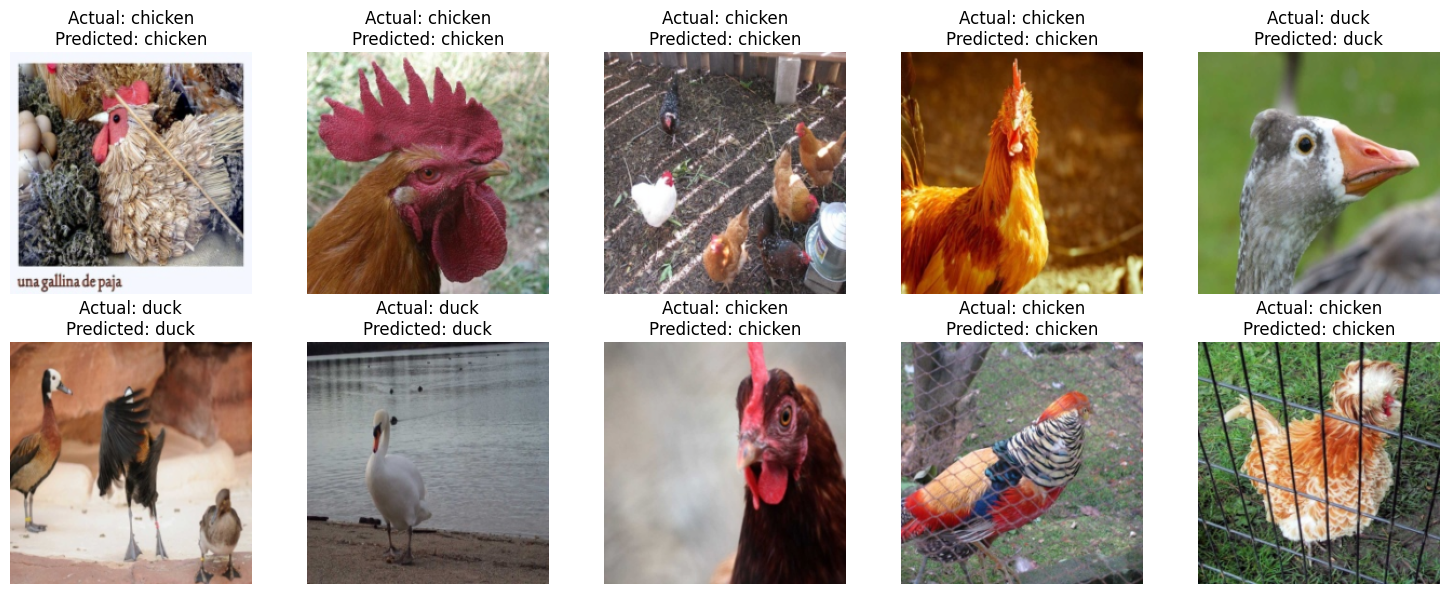

In [18]:
# Display random sample predictions
num_samples = 10  # Number of random samples to display (2 rows x 5 columns)
random_indices = random.sample(range(len(sample_images_list)), num_samples)

# Create a grid with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2x5 axes array to easily loop through them
axes = axes.flatten()

# Loop through the random indices and display each image with its actual and predicted labels
for i, idx in enumerate(random_indices):
    # Unnormalize the image
    image = sample_images_list[idx].permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    image = np.clip(image, 0, 1)  # Clip values to valid range

    # Get the actual and predicted labels
    actual_label = train_data.classes[sample_labels_list[idx]]  # Actual label from dataset
    predicted_label = train_data.classes[sample_predictions_list[idx]]  # Predicted label from model

    # Plot the image and add title with actual and predicted labels
    axes[i].imshow(image)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
